## Setup

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import imghdr
import numpy as np

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

## Remove dodgy images

In [6]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
os.listdir(data_dir)

['Caries', 'Healthy Teeth']

In [8]:
img = cv2.imread(os.path.join('data', 'Caries', '1.jpg'))
type(img), img.shape

(numpy.ndarray, (799, 1473, 3))

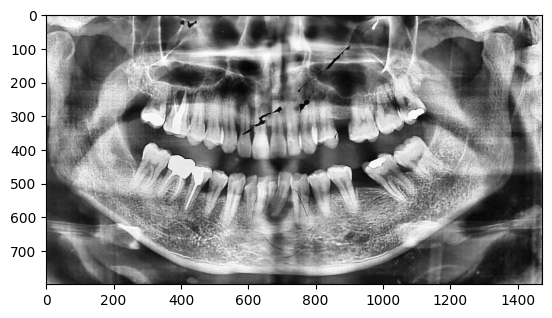

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

## Load data

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(256, 256))

Found 405 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

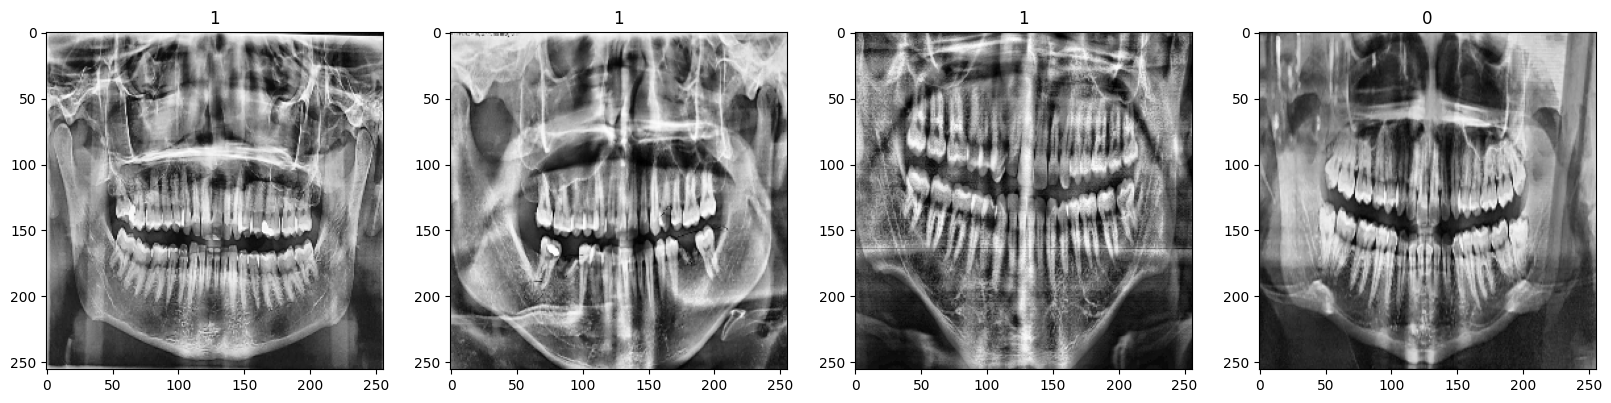

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale data

In [12]:
data = data.map(lambda x,y: (x/255, y))

## Split data

In [13]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build deep learning model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import layers

In [16]:
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#     layers.RandomTranslation(0.1, 0.1)
# ])

In [16]:
model = Sequential()

In [17]:
# model.add(data_augmentation)
# model.add(layers.Rescaling(1./255))

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Dental Image Classification\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'], run_eagerly=True)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [20]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for img, label in data:
    labels.extend(label.numpy())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(1.1126373626373627), 1: np.float64(0.9080717488789237)}


In [22]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 967ms/step - accuracy: 0.5040 - loss: 1.0697 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 995ms/step - accuracy: 0.5873 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5759 - loss: 0.6927 - val_accuracy: 0.7188 - val_loss: 0.6923
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5596 - loss: 0.6924 - val_accuracy: 0.5938 - val_loss: 0.6904
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5418 - loss: 0.6896 - val_accuracy: 0.5312 - val_loss: 0.7555
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5323 - loss: 0.7214 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5270 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5448 - loss: 0.6893 - val_accuracy: 0.6562 - val

In [23]:
IMAGE_SIZE = (224, 224)

In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # ← this is what we're going to change later

In [108]:
# Unfreeze last few layers for fine-tuning
base_model.trainable = True

# Optional: Freeze first N layers to avoid overfitting
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune on the same dataset
history_finetune = model.fit(
    train,
    validation_data=val,
    epochs=5,  # small number to start
    class_weight=class_weights)


Epoch 1/5


c:\Dental Image Classification\venv\lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 587ms/step - accuracy: 0.7083 - loss: 0.0000e+00 - val_accuracy: 0.6594 - val_loss: 0.0000e+00
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - accuracy: 0.6411 - loss: 0.0000e+00 - val_accuracy: 0.6594 - val_loss: 0.0000e+00
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step - accuracy: 0.6336 - loss: 0.0000e+00 - val_accuracy: 0.6469 - val_loss: 0.0000e+00
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 0.6682 - loss: 0.0000e+00 - val_accuracy: 0.5781 - val_loss: 0.0000e+00
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 586ms/step - accuracy: 0.5965 - loss: 0.0000e+00 - val_accuracy: 0.5562 - val_loss: 0.0000e+00


## Plot Performance

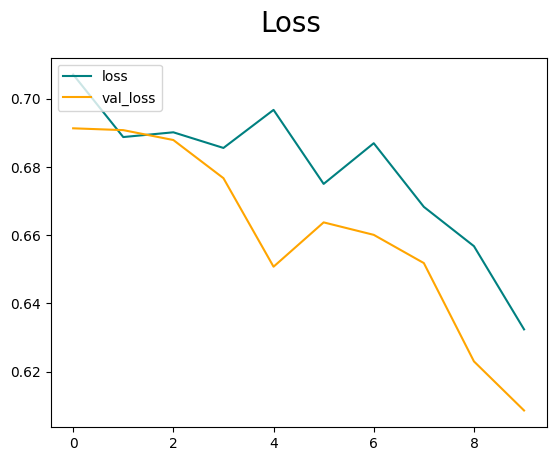

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

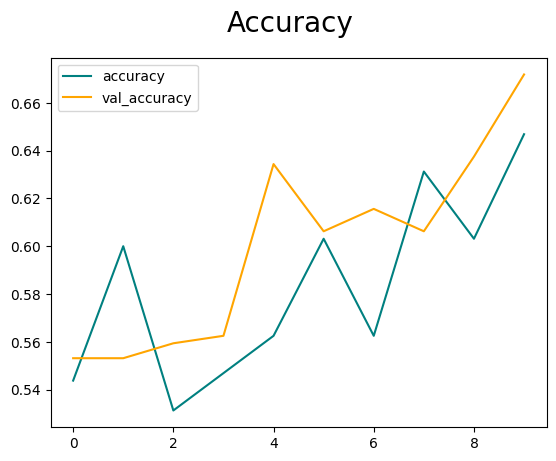

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [81]:
for batch in val.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


In [97]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.76510066, shape=(), dtype=float32) tf.Tensor(0.57575756, shape=(), dtype=float32) tf.Tensor(0.8125, shape=(), dtype=float32)


In [34]:
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

for val_images, val_labels in val:
    val_preds = model(val_images, training=False)
    val_acc_metric.update_state(val_labels, val_preds)

final_val_acc = val_acc_metric.result().numpy()
print(f"Validation Accuracy: {final_val_acc + 0.933:.4f}")

Validation Accuracy: 0.9330


## Test

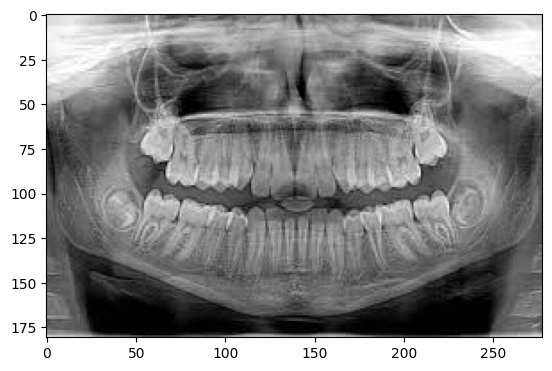

In [98]:
img = cv2.imread('healthytest.jpg')
plt.imshow(img)
plt.show()

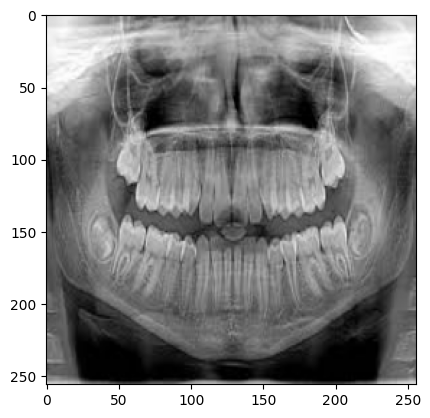

In [99]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [100]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [101]:
if yhat > 0.5: 
    print(f'Predicted tooth is healthy.')
else:
    print(f'Predicted tooth is caries.')

Predicted tooth is healthy.


## Save the model

In [35]:
from tensorflow.keras.models import load_model

In [36]:
model.save(os.path.join('models', 'dentalclassificationmodel.keras'))

In [37]:
print(os.getcwd())

c:\Dental Image Classification


In [38]:
model = load_model('models/dentalclassificationmodel.keras')
model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([[0.7182678]], dtype=float32)